In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# import sigpy.plot as pl

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

import numpy as np
import SimpleITK as sitk

import subtle.utils.io as suio
import subtle.subtle_preprocess as supre

from skimage.morphology import binary_closing
from skimage import color

import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from glob import glob

def get_rgb(img):
    img = (img - np.min(img))/np.ptp(img)
    return np.dstack((img, img, img))

def overlay_rgb(base_vol, ovr_vol, sl_idx, ch_idx=0, alpha=0.5):
    img_a = get_rgb(base_vol[sl_idx])
    img_b = get_rgb(ovr_vol[sl_idx])
    
    img_a[..., ch_idx] = img_b[..., 0] * alpha
    return img_a
    
def slice_preview(img_vol, interval=7, disp=True):
    n_rows = 7
    n_cols = 6
    idx = interval
    all_imgs = []
    bflag = False
    for c in range(n_cols):
        img_rows = []
        for r in range(n_rows):
            if idx >= img_vol.shape[0]:
                img_rows.append(np.zeros_like(img_vol[0]))
                bflag = True
            else:
                img_rows.append(img_vol[idx])
            idx += interval
                
        all_imgs.append(np.hstack(img_rows))
        if bflag:
            break
    
    img_disp = np.vstack(all_imgs)
    
    if not disp:
        return img_disp
    
    plt.imshow(img_disp)
    plt.axis('off')
    plt.show()

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

In [10]:
base_path = '/raid/SubtleGAD_Stanford/lowcon/Patient_0187/10_AX_T2'
t2_vol, hdr = suio.dicom_files(base_path)
t2_spacing = np.array([float(hdr.PixelSpacing[0]), float(hdr.PixelSpacing[1]), float(hdr.SliceThickness)])

data_full = np.load('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0187.npy')

t1_pre = data_full[0, :, 0]
t1_meta = suio.load_h5_metadata('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0187_meta.h5')

In [11]:
pmap = sitk.GetDefaultParameterMap('rigid')
ref_fixed = supre.dcm_to_sitk('/home/srivathsa/projects/studies/gad/stanford/data/Patient_0187/8_AX_BRAVO')
ref_moving = supre.dcm_to_sitk(base_path)

fixed_spacing = t1_meta['pixel_spacing_zero']
t2_reg, reg_params = supre.register_im(t1_pre, t2_vol, param_map=pmap, im_fixed_spacing=fixed_spacing, 
                                       im_moving_spacing=t2_spacing, ref_fixed=ref_fixed, ref_moving=ref_moving)

image registration
registration done, 14.4 s


In [12]:
print(t1_pre.min(), t1_pre.max())
print(t2_reg.min(), t2_reg.max())
t2_sc = np.interp(t2_reg, (t2_reg.min(), t2_reg.max()), (t1_pre.min(), t1_pre.max()))
# plt.imshow(t2_sc[150])
# plt.colorbar()

0.0 11.855304
0.0 6087.844


In [13]:
nse_mask = supre.mask_im(np.array([t2_reg]))[0]
t2_nse = nse_mask * t2_reg

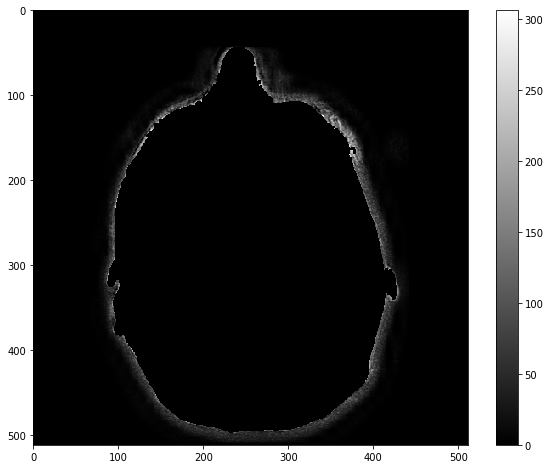

In [14]:
plt.imshow(t2_reg[150] - t2_nse[150])
plt.colorbar()

(3072, 3584)


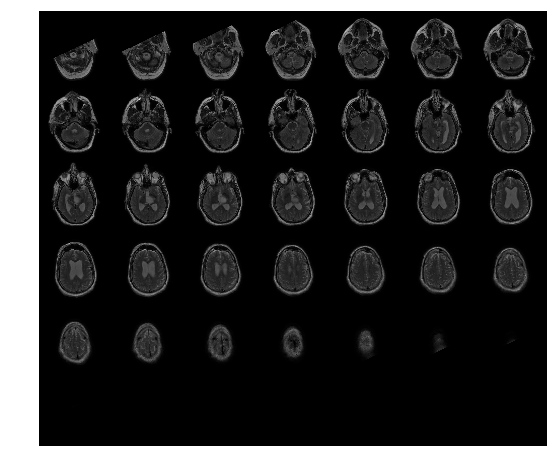

In [111]:
slice_preview(t2_reg)

In [59]:
suio.write_dicoms('/home/srivathsa/projects/studies/gad/stanford/data/Patient_0187/8_AX_BRAVO', t2_reg, 
             '/home/srivathsa/projects/T2_REG_Patient_0187', series_desc_pre='', series_desc_post='T2_REG')

100%|██████████| 364/364 [00:04<00:00, 80.87it/s]


In [15]:
mask = data_full[1, :, 2] > 0.1
mask = binary_closing(mask)

t2_m = t2_reg * mask

1390.4607421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


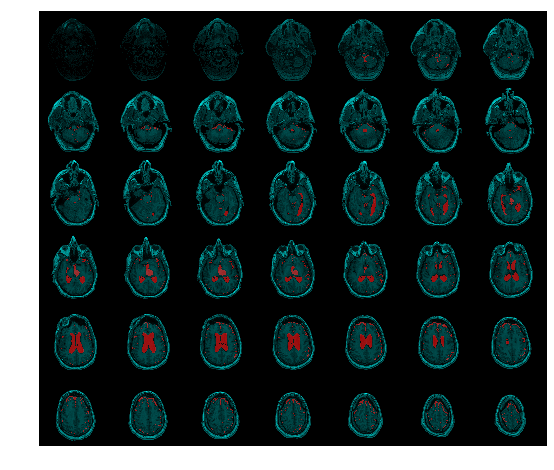

In [16]:
qnts = np.quantile(t2_reg[mask], 0.9)
print(qnts)
t2_th = (t2_m >= qnts).astype(t1_pre.dtype)

t1_disp = slice_preview(t1_pre, disp=False)
csf_disp = slice_preview(t2_th, disp=False)

t1_rgb = get_rgb(t1_disp)
csf_rgb = get_rgb(csf_disp)

t1_rgb[..., 0] = csf_rgb[..., 0] * 0.5

disp_scale = 1.2
plt.imshow(disp_scale * t1_rgb, vmin=t1_pre.min(), vmax=t1_pre.max())
plt.axis('off')
plt.savefig('t2_csf.png')

# disp = overlay_rgb(t1_pre, t2_th, sl_idx=182, ch_idx=0)


# plt.imshow(disp_scale * disp, vmin=disp.min(), vmax=disp.max())

In [141]:
df_t2qc = pd.read_csv('/home/srivathsa/projects/studies/gad/stanford/t2_qc.csv')
src_path = '/raid/SubtleGAD_Stanford/lowcon'
dest_path = '/home/srivathsa/projects/studies/gad/stanford/data'
for idx, row in df_t2qc.iterrows():
    if 'T2' not in row['scan']:
        continue
    case_num = 'Patient_{:04d}'.format(row['subject'])
    t2_path = '{}/{}/{}'.format(src_path, case_num, row['scan'])
    target_path = '{}/{}/{}'.format(dest_path, case_num, row['scan'])
    if not os.path.exists('{}/{}'.format(dest_path, case_num)):
        continue
    if not os.path.exists(target_path) and os.path.exists(t2_path):
        os.symlink(t2_path, target_path)

In [19]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/data/Patient*'
scans = sorted([p for p in glob(base_path)])
t2_emplist = []
for sdir in scans:
    dcmdirs = [t2p for t2p in glob('{}/*'.format(sdir)) if 'T2' in t2p]
    if len(dcmdirs) == 0:
        t2_emplist.append(sdir.split('/')[-1])
print(t2_emplist)

['Patient_0417']


In [18]:
for case_num in t2_emplist:
    t2_dirs = sorted([p for p in glob('/raid/SubtleGAD_Stanford/lowcon/{}/*T2*'.format(case_num))])
    t2_dirs = [d for d in t2_dirs if 'FLAIR' not in d]
    if len(t2_dirs) > 0:
        t2d = t2_dirs[0]
        dir_dest = t2d.split('/')[-1]
        dest = '/home/srivathsa/projects/studies/gad/stanford/data/{}/{}'.format(case_num, dir_dest)
        os.symlink(t2d, dest)

In [3]:
t2_proc = np.load('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0088_T2.npy')

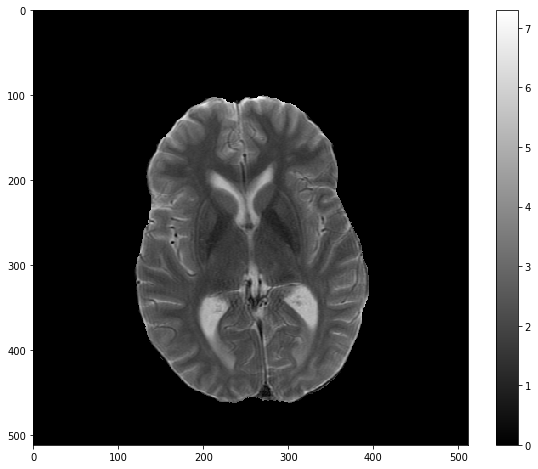

In [8]:
plt.imshow(t2_proc[1, 168])
plt.colorbar()

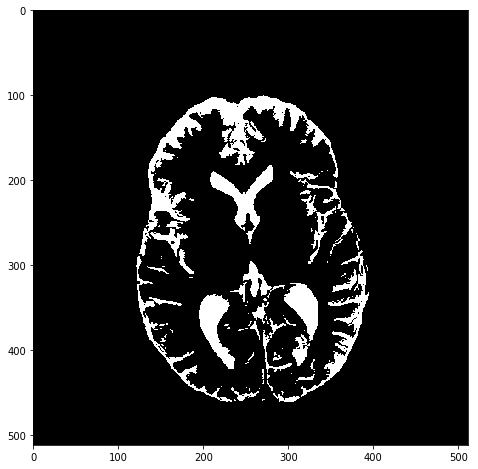

In [5]:
th = np.quantile(t2_proc[0], 0.9)
t2_th = t2_proc[0] >= th
t2m = (t2_proc[1] > 0.1)

plt.imshow(t2m[168] * t2_th[168])

In [14]:
h5_files = [f for f in glob('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/*.npy') if 'meta' not in f]
h5_cases = [f.split('/')[-1].replace('.npy', '') for f in h5_files]
print(len(h5_cases))

440


In [16]:
sorted(h5_cases)

['Patient_0085',
 'Patient_0086',
 'Patient_0088',
 'Patient_0088_T2',
 'Patient_0089',
 'Patient_0090',
 'Patient_0092',
 'Patient_0093',
 'Patient_0095',
 'Patient_0096',
 'Patient_0097',
 'Patient_0099',
 'Patient_0101',
 'Patient_0102',
 'Patient_0103',
 'Patient_0104',
 'Patient_0105',
 'Patient_0106',
 'Patient_0107',
 'Patient_0108',
 'Patient_0109',
 'Patient_0110',
 'Patient_0112',
 'Patient_0113',
 'Patient_0114',
 'Patient_0115',
 'Patient_0116',
 'Patient_0117',
 'Patient_0118',
 'Patient_0119',
 'Patient_0120',
 'Patient_0121',
 'Patient_0122',
 'Patient_0123',
 'Patient_0124',
 'Patient_0125',
 'Patient_0126',
 'Patient_0127',
 'Patient_0128',
 'Patient_0129',
 'Patient_0130',
 'Patient_0131',
 'Patient_0132',
 'Patient_0133',
 'Patient_0134',
 'Patient_0135',
 'Patient_0136',
 'Patient_0137',
 'Patient_0138',
 'Patient_0139',
 'Patient_0140',
 'Patient_0141',
 'Patient_0142',
 'Patient_0143',
 'Patient_0144',
 'Patient_0145',
 'Patient_0146',
 'Patient_0147',
 'Patient_0